# Machine Learning

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !pip install ipython-autotime
 %load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
time: 612 µs (started: 2024-04-25 21:43:22 +00:00)


### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer, AutoTokenizer, ElectraModel
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

import scipy
import itertools
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


time: 27.3 s (started: 2024-04-25 21:43:23 +00:00)


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

time: 1.41 s (started: 2024-04-25 21:43:50 +00:00)


### Dataset

In [ ]:
dataset_path = '../Data/dataset_3_nonbalanced.csv'
df = pd.read_csv(dataset_path)

time: 8.87 s (started: 2024-04-25 21:43:51 +00:00)


## Odstránenie autorov, ktorý boli odstránení aj pri preprocessingu pre modely NN

In [ ]:
dataset = df[~df['author_id'].isin([69, 251, 53])]

time: 23.9 ms (started: 2024-04-25 21:44:00 +00:00)


In [ ]:
dataset.head()

,author_id,text
0,168,When the travelers had proceeded half a dozen ...
1,168,", The large sums which Philip had received for..."
2,168,"""I may state,"" continued the detective, ""that ..."
3,168,Pretty soon the deacon took his hat and cane a...
4,168,Later in the day the two friends began to make...


time: 1.2 s (started: 2024-04-25 21:44:00 +00:00)


In [ ]:
nan_values = dataset.isnull().sum()
nan_values

author_id     0
text         17
dtype: int64

time: 22.7 ms (started: 2024-04-25 21:44:02 +00:00)


In [ ]:
 dataset = dataset.dropna()

time: 4.51 ms (started: 2024-04-25 21:44:02 +00:00)


<Axes: xlabel='author_id', ylabel='count'>

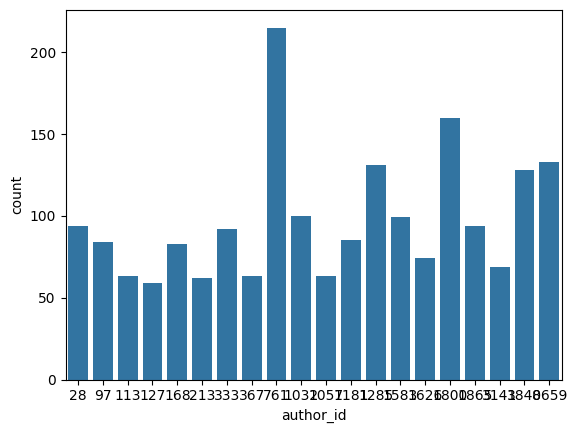

time: 788 ms (started: 2024-04-25 21:44:02 +00:00)


In [ ]:
sns.countplot(x='author_id', data=dataset)

### Preprocessing

In [ ]:
def preprocess_text(text):
    # Odstránenie non-ASCII znakov
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Odstránenie čísel
    text = re.sub(r'\d+', '', text)
    # Odstránenie interpunkcie
    text = re.sub(r'[^\w\s]', '', text)
    # Prevod na malé písmena
    text = text.lower()
    # Odstránenie stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    # Lemmatizácia
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return ' '.join(lemmatized_words)


time: 1.36 ms (started: 2024-04-25 21:44:02 +00:00)


In [ ]:
dataset['processed_text'] = dataset['text'].apply(preprocess_text)

time: 3min 10s (started: 2024-04-25 21:44:02 +00:00)


In [ ]:
dataset.head()

,author_id,text,processed_text
0,168,When the travelers had proceeded half a dozen ...,traveler proceeded half dozen mile way horse s...
1,168,", The large sums which Philip had received for...",large sum philip received playing might dazzle...
2,168,"""I may state,"" continued the detective, ""that ...",may state continued detective indirectly cause...
3,168,Pretty soon the deacon took his hat and cane a...,pretty soon deacon took hat cane went mr hopki...
4,168,Later in the day the two friends began to make...,later day two friend began make inquiry overla...


time: 1.62 s (started: 2024-04-25 21:47:13 +00:00)


### Rozdelenie dát na test / train data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.processed_text, dataset.author_id, test_size=0.20, random_state=13, stratify=dataset.author_id)

time: 7.3 ms (started: 2024-04-25 21:47:15 +00:00)


In [ ]:
print('Train')
print(y_train.value_counts())
print('Test')
print(y_test.value_counts())

Train
author_id
761     172
1800    128
8659    106
1285    105
3840    102
1032     80
1583     79
28       75
1865     75
333      74
1181     68
97       67
168      66
1626     59
3141     55
367      51
113      51
213      50
1057     50
127      47
Name: count, dtype: int64
Test
author_id
761     43
1800    32
8659    27
3840    26
1285    26
1583    20
1032    20
28      19
1865    19
333     18
97      17
168     17
1181    17
1626    15
3141    14
1057    13
367     12
127     12
113     12
213     12
Name: count, dtype: int64
time: 9.07 ms (started: 2024-04-25 21:47:15 +00:00)


## Vektorizácia

## Bag of Words


In [ ]:
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

time: 11.5 s (started: 2024-04-24 10:56:03 +00:00)


### Logistická regresia

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_vect, y_train)

y_pred = model.predict(X_test_vect)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9667519181585678
F1 score: 0.9678424092975804
Precision: 0.9734434836736627
Recall: 0.9667519181585678
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0 10  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 42  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 20  0 

### Naive-Bayes

In [ ]:
classifier = MultinomialNB()

classifier.fit(X_train_vect, y_train)

predicted_labels = classifier.predict(X_test_vect)

test_accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')
precision = precision_score(y_test, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))


Accuracy: 0.8644501278772379
F1 score: 0.8461574791677302
Precision: 0.9057433025911286
Recall: 0.8644501278772379
Confusion Matrix:
 [[15  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  2  0]
 [ 0  0 11  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  1  0  0  0  0  0  0  1  0  0  3  0]
 [ 0  0  0  0 13  0  0  0  2  1  0  0  0  0  0  0  0  0  0  1]
 [ 0  1  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  1  3  0  0  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 20  0 

## TF - IDF

In [ ]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

time: 14.4 s (started: 2024-04-25 21:47:15 +00:00)


### Logistická regresia

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9462915601023018
F1 score: 0.9438187064554638
Precision: 0.9530538658486674
Recall: 0.9462915601023018
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0 10  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  2  0  0  0  1  0  0  0  0  0  3  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 20  0 

### Naive-Bayes

In [ ]:
classifier = MultinomialNB()

classifier.fit(X_train_tfidf, y_train)

predicted_labels = classifier.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')
precision = precision_score(y_test, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))


Accuracy: 0.4040920716112532
F1 score: 0.352927742532821
Precision: 0.5013027903002532
Recall: 0.4040920716112532
Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  2 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  1  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0 14  0  

## GloVe


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = '/content/drive/MyDrive/glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)


<ipython-input-23-5c75194aba4b>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 300)

time: 3min 12s (started: 2024-04-24 10:58:09 +00:00)


In [ ]:
import numpy as np
from gensim.models import KeyedVectors

glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

def document_vector(doc):
    words = doc.split()
    valid_words = [word for word in words if word in glove_model.key_to_index]
    if not valid_words:
        return np.zeros(glove_model.vector_size)
    doc_embedding = np.mean(glove_model[valid_words], axis=0)
    return doc_embedding

processed_texts = dataset['processed_text'].tolist()

embedding_matrix = np.array([document_vector(doc) for doc in processed_texts])


time: 2min 41s (started: 2024-04-24 11:01:21 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

labels = dataset['author_id'].tolist()

X_train, X_test, y_train, y_test = train_test_split(embedding_matrix, labels, test_size=0.2, random_state=42)


time: 3.89 ms (started: 2024-04-24 11:04:02 +00:00)


In [ ]:
print(X_train)
print(y_train)

[[-0.0621851   0.01916992 -0.03510184 ... -0.10551985 -0.05403889
   0.06547548]
 [-0.05857228  0.00889115 -0.02415835 ... -0.06317864 -0.03367142
   0.10305983]
 [-0.08019575  0.03815246 -0.0284771  ... -0.07829931 -0.05051672
   0.05299292]
 ...
 [-0.0826022   0.01073561 -0.07579511 ... -0.05373921 -0.02315423
   0.11405005]
 [-0.06346951 -0.0004349  -0.03120526 ... -0.05603637 -0.02890811
   0.07805251]
 [-0.05399887 -0.01602081 -0.03938898 ... -0.0651796  -0.03691308
   0.03740252]]
[8659, 3840, 97, 28, 113, 113, 213, 1800, 761, 1057, 3840, 1626, 8659, 127, 1285, 97, 1865, 168, 367, 1626, 333, 1800, 8659, 213, 333, 1032, 28, 28, 3840, 1800, 1057, 1285, 1800, 1285, 127, 761, 127, 1285, 3840, 3141, 1032, 1800, 1583, 97, 97, 1800, 1032, 8659, 761, 97, 1800, 1800, 1032, 1032, 1032, 28, 1583, 761, 1032, 97, 8659, 761, 113, 8659, 8659, 1057, 127, 1865, 1800, 8659, 28, 1800, 1626, 28, 3840, 3141, 1626, 1800, 333, 97, 1181, 1032, 1800, 3141, 1181, 1583, 97, 3840, 1865, 8659, 761, 1285, 761

### Logistická regresia

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8005115089514067
F1 score: 0.7890436855134824
Precision: 0.8345234051107002
Recall: 0.8005115089514067
Confusion Matrix:
 [[13  0  0  0  0  0  0  0  8  0  0  0  1  0  0  1  0  0  0  0]
 [ 2 10  0  0  0  0  0  0  1  0  0  0  0  0  0  1  1  0  1  0]
 [ 1  7  8  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  1  0  0  0  1  0  0  0  0  0  1  0]
 [ 1  0  0  0 16  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  1  0  0  0  1  0  0  5  0  0  0  4  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  3  1]
 [ 0  0  0  0  1  0  0  8  0  1  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 42  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  2  0 10  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1 21  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 14  0 

### Naive-Bayes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

time: 12 ms (started: 2024-04-24 11:04:03 +00:00)


In [ ]:
classifier = MultinomialNB()

classifier.fit(X_train_scaled, y_train)

predicted_labels = classifier.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')
precision = precision_score(y_test, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))

Accuracy: 0.710997442455243
F1 score: 0.7063999900246366
Precision: 0.7905420062244046
Recall: 0.710997442455243
Confusion Matrix:
 [[12  0  0  0  0  0  0  0 10  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  8  0  0  0  0  1  1  3  0  0  0  1  0  0  1  1  0  0  0]
 [ 1  9  6  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  3  0  0  0  1  0  0  0  0  0  1  0]
 [ 1  0  0  0 15  0  0  0  1  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  1  0  0  0  2  0  0  4  0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  1  0  0  0  0  0  3  2]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  3  0  2  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 40  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  0 16  0  0  0  0  1  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  2  0  6  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  3  0  0  0 18  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 14  0  0

## Word2Vec

In [ ]:
model_path = '../Data/GoogleNews-vectors-negative300.bin'
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

time: 1min 24s (started: 2024-04-24 11:04:04 +00:00)


In [ ]:
def document_vector(model, doc):
    words = doc.split()
    valid_words = [word for word in words if word in model.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean(model[valid_words], axis=0)


time: 983 µs (started: 2024-04-24 11:05:28 +00:00)


In [ ]:
document_vectors = np.array([document_vector(w2v_model, doc) for doc in dataset['processed_text']])

time: 54.4 s (started: 2024-04-24 11:05:28 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(document_vectors, dataset['author_id'], test_size=0.2, random_state=42)

time: 3.48 ms (started: 2024-04-24 11:06:22 +00:00)


### Logistická regresia

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5626598465473146
F1 score: 0.5110044460062053
Precision: 0.5643269755494535
Recall: 0.5626598465473146
Confusion Matrix:
 [[ 5  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  1  0]
 [ 1  1  0  0  0  0  0  0 10  0  0  0  3  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0 14  0  0  0  2  0  0  0  0  0  1  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0 10  0  0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  8  5]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  2  0  0  0  2  0  4  0]
 [ 0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  1  6]
 [ 0  0  0  0  0  0  0  0  8  0  0  0  4  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0 10  0  0  5  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0 12  0 

### Naive-Bayes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

time: 10.4 ms (started: 2024-04-24 11:06:23 +00:00)


In [ ]:
X_train_scaled

array([[0.83245325, 0.64873224, 0.3045764 , ..., 0.51684654, 0.3477689 ,
        0.08396116],
       [0.88608444, 0.60381293, 0.43379945, ..., 0.5312569 , 0.27832347,
        0.14301324],
       [0.87866247, 0.46403086, 0.38982219, ..., 0.6220739 , 0.35769817,
        0.09552202],
       ...,
       [0.8792023 , 0.49017614, 0.5815418 , ..., 0.5433097 , 0.29165408,
        0.1315116 ],
       [0.90316796, 0.53735507, 0.5080085 , ..., 0.49889374, 0.35742748,
        0.145736  ],
       [0.89062655, 0.6500413 , 0.30675268, ..., 0.62916017, 0.33682793,
        0.11145963]], dtype=float32)

time: 4.95 ms (started: 2024-04-24 11:06:23 +00:00)


In [ ]:
classifier = MultinomialNB()

classifier.fit(X_train_scaled, y_train)

predicted_labels = classifier.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')
precision = precision_score(y_test, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))

Accuracy: 0.6521739130434783
F1 score: 0.6310421141502279
Precision: 0.7294564239162304
Recall: 0.6521739130434783
Confusion Matrix:
 [[ 8  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  7  0  0  0  0  1  1  5  0  0  0  1  0  0  0  1  0  0  0]
 [ 0  7  6  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  4  0  0  0  1  0  0  0  0  0  1  0]
 [ 1  0  0  0 15  0  0  0  1  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  0  5  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  1  0  0  0  0  0  3  3]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  4  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 41  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0 17  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  1  0  1  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0 17  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0 13  0 

## Bert

In [ ]:
from transformers import BertTokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertModel.from_pretrained(model_name)

def bert_encode(document, tokenizer, model):
    inputs = tokenizer(document, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embeddings



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

time: 14.3 s (started: 2024-04-24 11:06:23 +00:00)


In [ ]:
documents = dataset['processed_text']
labels = dataset['author_id']

embeddings = np.vstack([bert_encode(doc, tokenizer, model) for doc in documents])

time: 1h 43min 50s (started: 2024-04-24 11:06:37 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)

time: 71 ms (started: 2024-04-24 12:50:28 +00:00)


### Logistická regresia

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7800511508951407
F1 score: 0.7741744930358506
Precision: 0.7801136644784196
Recall: 0.7800511508951407
Confusion Matrix:
 [[18  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 10  1  0  0  1  0  0  0  0  0  0  2  0  0  1  1  0  1  0]
 [ 0  2  9  0  0  1  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  1  0 14  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  1  0  2  1  0  1  0  0  0  2  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  6  0  0  0  0  0  0  0  0  0  2  1  0  2]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  0  0  1 12  0  0  0  0  0  1  0  1  1  2]
 [ 0  0  0  0  0  0  1  0  0  0  6  0  0  0  0  1  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 23  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  2  1  0  0 25  0  0  1  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0 22  0 

### Naive-Bayes

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

time: 16.9 ms (started: 2024-04-24 12:50:36 +00:00)


In [ ]:
classifier = MultinomialNB()

classifier.fit(X_train_scaled, y_train)

predicted_labels = classifier.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')
precision = precision_score(y_test, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))

Accuracy: 0.649616368286445
F1 score: 0.646654341585347
Precision: 0.684727603020533
Recall: 0.649616368286445
Confusion Matrix:
 [[12  1  0  1  0  0  0  0  5  0  0  0  0  0  0  1  0  0  0  0]
 [ 1  9  1  0  0  1  0  0  3  0  0  0  1  0  0  1  0  0  0  0]
 [ 0  1  8  0  0  0  0  0  5  0  1  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  3  0  0  0  0  2  0  0  0  0  0  0  1  0  0  2  0]
 [ 0  0  0  0 10  0  1  0  2  0  1  0  0  0  0  0  0  0  1  2]
 [ 1  0  0  0  0  2  0  0  4  0  0  1  1  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  4  0  1  1  1  0  0  0  0  0  0  1  1  2]
 [ 0  0  0  0  0  0  1 10  0  0  0  0  1  0  1  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0 36  0  0  0  1  3  0  2  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  2 11  0  0  0  1  0  0  0  0  2  3]
 [ 0  0  0  0  0  0  1  0  4  0  4  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0 22  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  5  3  0  0 20  0  0  1  1  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0 22  0  0  

## DistilBert

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def bert_encode(document, tokenizer, model):
    inputs = tokenizer(document, max_length=512, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embeddings



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

time: 8.52 s (started: 2024-04-24 12:50:36 +00:00)


In [ ]:
documents = dataset['processed_text']
labels = dataset['author_id']

embeddings = np.vstack([bert_encode(doc, tokenizer, model) for doc in documents])

time: 44min 58s (started: 2024-04-24 12:50:44 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)

time: 61.3 ms (started: 2024-04-24 13:35:43 +00:00)


### Logistická regresia

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7672634271099744
F1 score: 0.7626604591883435
Precision: 0.78071122540432
Recall: 0.7672634271099744
Confusion Matrix:
 [[12  0  1  0  0  0  0  0  7  0  0  0  0  1  0  1  0  0  0  0]
 [ 0 17  0  0  1  0  0  1  2  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0 11  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  3  0  0  0  0  2  1  0  0  0  0  0  2  0  1  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  3  0  0  0  1  0  0  1  0  0  2  0]
 [ 0  0  0  1  0  0 14  0  1  0  0  0  0  0  0  1  0  0  2  3]
 [ 0  0  0  0  0  0  0 11  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 43  0  1  0  0  2  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  1  0  0  0  6]
 [ 1  0  0  0  0  0  0  0  2  0 11  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  1  1  1  0  0  0  0  0  1  0  0 22  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0

### Naive-Bayes

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

time: 20.7 ms (started: 2024-04-24 13:35:50 +00:00)


In [ ]:
classifier = MultinomialNB()

classifier.fit(X_train_scaled, y_train)

predicted_labels = classifier.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')
precision = precision_score(y_test, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))

Accuracy: 0.6112531969309463
F1 score: 0.5993498848865935
Precision: 0.6341165125760061
Recall: 0.6112531969309463
Confusion Matrix:
 [[ 7  0  0  0  0  0  0  0 11  0  0  0  0  1  0  2  0  0  1  0]
 [ 0 14  0  0  0  0  1  1  3  0  1  0  1  0  0  0  1  0  0  0]
 [ 0  0 10  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  0  4  0  0  0  0  0  0  2  0  1  1  0]
 [ 0  0  0  0 10  0  0  0  1  0  0  0  0  0  2  0  0  1  1  0]
 [ 1  0  0  0  0  2  1  0  3  0  0  0  4  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  9  1  4  0  0  0  2  1  0  1  0  0  1  3]
 [ 0  1  0  0  0  0  0 10  0  0  0  0  1  0  1  0  0  0  0  0]
 [ 1  0  1  1  0  0  0  0 38  0  1  0  1  3  0  1  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  1 13  0  1  1  1  0  0  0  0  4  3]
 [ 1  0  0  0  0  0  0  0  4  0  6  0  1  0  0  0  1  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  2  1  1  1  0  1  0  0  0  0  0 16  1  0  1  1  0  2  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  9  0 

time: 111 ms (started: 2024-04-24 13:35:50 +00:00)


## Electra

In [ ]:
model_name = 'google/electra-small-discriminator'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = ElectraModel.from_pretrained(model_name)

def electra_encode(document, tokenizer, model):
    inputs = tokenizer(document, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embeddings



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

time: 11 s (started: 2024-04-24 13:35:50 +00:00)


In [ ]:
documents = dataset['processed_text']
labels = dataset['author_id']

embeddings = np.vstack([electra_encode(doc, tokenizer, model) for doc in documents])

time: 15min 2s (started: 2024-04-24 13:36:01 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)

time: 40.3 ms (started: 2024-04-24 13:51:03 +00:00)


### Logistická regresia

In [ ]:
model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6879795396419437
F1 score: 0.6844494238745794
Precision: 0.6955748175923883
Recall: 0.6879795396419437
Confusion Matrix:
 [[12  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  9  1  0  0  0  1  0  0  2  2  0  1  0  2  1  0  1  0  0]
 [ 0  1  6  0  1  1  1  0  4  0  2  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  7  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0 14  0  0  0  0  2  1  0  0  0  0  1  0  0  1  0]
 [ 0  2  0  0  3  4  0  0  1  0  1  0  1  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  2  1  0  0  1  0  1  1  0  0  3  1]
 [ 0  0  0  0  0  1  0 10  0  0  0  0  0  0  1  0  0  0  2  1]
 [ 0  1  0  0  1  0  0  0 30  1  1  0  0  1  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0  0 17  2  0  0  0  0  1  0  0  0  3]
 [ 0  1  0  0  1  0  1  1  0  0  1  0  1  0  0  2  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 1  1  0  1  0  2  0  0  2  0  2  0 14  0  0  2  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0 20  0 

### Naive-Bayes

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

time: 22.5 ms (started: 2024-04-24 13:51:06 +00:00)


In [ ]:
classifier = MultinomialNB()

classifier.fit(X_train_scaled, y_train)

predicted_labels = classifier.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')
precision = precision_score(y_test, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='weighted')

print('Accuracy:', test_accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))

Accuracy: 0.3836317135549872
F1 score: 0.34637610905217864
Precision: 0.4302017657275387
Recall: 0.3836317135549872
Confusion Matrix:
 [[ 6  0  0  0  0  0  0  0  6  0  0  0  0  0  0  1  0  1  1  0]
 [ 0  1  0  0  0  0  1  0  2  3  0  0  2  0  0  4  1  0  2  4]
 [ 0  0  3  0  0  0  1  0  9  0  0  0  0  0  0  3  0  0  1  0]
 [ 0  0  0  0  0  0  1  1  2  0  0  0  1  0  0  0  0  0  2  3]
 [ 0  0  0  0  4  0  0  0  0  1  0  0  2  0  1  5  0  0  1  6]
 [ 0  0  0  0  1  0  0  0  6  0  0  0  1  0  0  3  0  0  2  0]
 [ 0  0  0  0  1  0  2  0  8  0  0  0  2  0  0  1  0  0  4  1]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  2  0  0  0  4  1]
 [ 2  0  0  0  0  0  1  0 27  1  0  0  1  1  0  2  1  0  0  1]
 [ 0  0  0  0  1  0  0  0  0  7  0  0  1  0  1  0  3  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  3  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  7  0  0  0  8  1  0  3  0  0  3  3]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  5  0